In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import zipfile
import io
import geopandas as gpd
import s3fs
import zarr
import dask 
import dask.array
import xarray as xr
import pandas as pd
from shapely.geometry import Point
from shapely.prepared import prep
import rioxarray




# Task 1 : Download the Texas shape file.

In [5]:
url = "https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_state_5m.zip"
response = requests.get(url)

if response.status_code == 200:
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall("path_to_extract")  # م

# بارگذاری فایل‌های استخراج شده
shapefile_path = "path_to_extract/cb_2023_us_state_5m.shp"
all_states = gpd.read_file(shapefile_path)
texas_shape = all_states[all_states['NAME'] == 'Texas'].to_crs('EPSG:4326')


<Figure size 1200x1000 with 0 Axes>

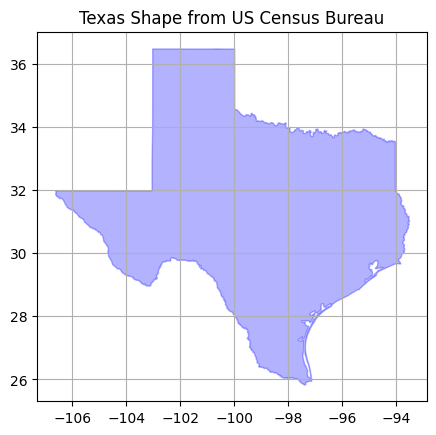

In [6]:
fig = plt.figure(figsize=(12, 10))
texas_shape.plot(edgecolor='blue', facecolor='blue', alpha=0.3)
plt.grid(True)
plt.title("Texas Shape from US Census Bureau")
plt.show()

In [7]:

base_url = 'noaa-nws-aorc-v1-1-1km' 
dataset_years = list(range(2020, 2022))
s3_out = s3fs.S3FileSystem(anon=True)
#store = s3fs.S3Map(root=f"{base_url}/{year}.zarr", s3=s3_out, check=False)

store = [s3fs.S3Map(
            root=f"noaa-nws-aorc-v1-1-1km/{dataset_year}.zarr",
            s3=s3fs.S3FileSystem(anon=True),
            check=False
        ) for dataset_year in dataset_years]


In [8]:
base_url = 'noaa-nws-aorc-v1-1-1km'
s3_out = s3fs.S3FileSystem(anon=True)

texas_bbox = texas_shape.bounds
minx, miny, maxx, maxy = texas_bbox.iloc[0]

print(f"Texas bounding box: {minx}, {miny}, {maxx}, {maxy}")

available_years = []
for year in range(2020, 2023):
    if s3_out.exists(f"{base_url}/{year}.zarr"):
        available_years.append(year)

print(f"Available years: {available_years}")
texas_datasets = []

for year in available_years:
    print(f"\nProcessing year: {year}")
    
    try:
        store = s3fs.S3Map(root=f"{base_url}/{year}.zarr", s3=s3_out, check=False)
        ds = xr.open_dataset(store, engine='zarr', chunks={'time': 720}) 
        lat_values = ds.latitude.values
        if lat_values[0] > lat_values[-1]:
            ds_texas_bbox = ds.sel(latitude=slice(maxy + 1, miny - 1))

        ds_texas_bbox = ds.sel(
            longitude=slice(minx - 1, maxx + 1),
            latitude=slice(miny - 1, maxy + 1)
        )

        
        ds_texas_bbox = ds_texas_bbox.rio.write_crs("EPSG:4326")
        ds_texas = ds_texas_bbox.rio.clip(texas_shape.geometry, drop=True)
        texas_datasets.append(ds_texas)  
    except Exception as e:
        print(f"Error processing year {year}: {e}")

Texas bounding box: -106.645479, 25.837377, -93.516407, 36.500704
Available years: [2020, 2021, 2022]

Processing year: 2020

Processing year: 2021

Processing year: 2022


In [9]:
ds_texas_bbox = ds_texas_bbox.rio.write_crs("EPSG:4326", inplace=True)
if texas_shape.crs != ds_texas_bbox.rio.crs:
    texas_shape = texas_shape.to_crs(ds_texas_bbox.rio.crs)

ds_texas = ds_texas_bbox.rio.clip(texas_shape.geometry, drop=True)
print("After clip:", ds_texas)


After clip: <xarray.Dataset> Size: 1TB
Dimensions:              (latitude: 1280, longitude: 1576, time: 8760)
Coordinates:
  * latitude             (latitude) float64 10kB 25.84 25.85 ... 36.49 36.5
  * longitude            (longitude) float64 13kB -106.6 -106.6 ... -93.52
  * time                 (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31...
    spatial_ref          int64 8B 0
Data variables:
    APCP_surface         (time, latitude, longitude) float64 141GB dask.array<chunksize=(720, 67, 13), meta=np.ndarray>
    DLWRF_surface        (time, latitude, longitude) float64 141GB dask.array<chunksize=(720, 67, 13), meta=np.ndarray>
    DSWRF_surface        (time, latitude, longitude) float64 141GB dask.array<chunksize=(720, 67, 13), meta=np.ndarray>
    PRES_surface         (time, latitude, longitude) float64 141GB dask.array<chunksize=(720, 67, 13), meta=np.ndarray>
    SPFH_2maboveground   (time, latitude, longitude) float64 141GB dask.array<chunksize=(720, 67, 13), meta=np.nd

In [10]:
print(ds)
print(ds.coords)
print(ds.data_vars)

<xarray.Dataset> Size: 20TB
Dimensions:              (time: 8760, latitude: 4201, longitude: 8401)
Coordinates:
  * time                 (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31...
  * latitude             (latitude) float64 34kB 20.0 20.01 20.02 ... 54.99 55.0
  * longitude            (longitude) float64 67kB -130.0 -130.0 ... -60.01 -60.0
Data variables:
    APCP_surface         (time, latitude, longitude) float64 2TB dask.array<chunksize=(720, 128, 256), meta=np.ndarray>
    DLWRF_surface        (time, latitude, longitude) float64 2TB dask.array<chunksize=(720, 128, 256), meta=np.ndarray>
    DSWRF_surface        (time, latitude, longitude) float64 2TB dask.array<chunksize=(720, 128, 256), meta=np.ndarray>
    PRES_surface         (time, latitude, longitude) float64 2TB dask.array<chunksize=(720, 128, 256), meta=np.ndarray>
    SPFH_2maboveground   (time, latitude, longitude) float64 2TB dask.array<chunksize=(720, 128, 256), meta=np.ndarray>
    TMP_2maboveground    (tim

In [32]:
print(ds.data_vars)

Data variables:
    APCP_surface         (time, latitude, longitude) float64 2TB dask.array<chunksize=(720, 128, 256), meta=np.ndarray>
    DLWRF_surface        (time, latitude, longitude) float64 2TB dask.array<chunksize=(720, 128, 256), meta=np.ndarray>
    DSWRF_surface        (time, latitude, longitude) float64 2TB dask.array<chunksize=(720, 128, 256), meta=np.ndarray>
    PRES_surface         (time, latitude, longitude) float64 2TB dask.array<chunksize=(720, 128, 256), meta=np.ndarray>
    SPFH_2maboveground   (time, latitude, longitude) float64 2TB dask.array<chunksize=(720, 128, 256), meta=np.ndarray>
    TMP_2maboveground    (time, latitude, longitude) float64 2TB dask.array<chunksize=(720, 128, 256), meta=np.ndarray>
    UGRD_10maboveground  (time, latitude, longitude) float64 2TB dask.array<chunksize=(720, 128, 256), meta=np.ndarray>
    VGRD_10maboveground  (time, latitude, longitude) float64 2TB dask.array<chunksize=(720, 128, 256), meta=np.ndarray>


In [11]:
print(ds_texas_bbox.longitude.min().values, ds_texas_bbox.longitude.max().values)
print(ds_texas_bbox.latitude.min().values, ds_texas_bbox.latitude.max().values)
print(texas_shape.total_bounds)


-107.64256100001808 -92.5181660000303
24.841473 37.4993
[-106.645479   25.837377  -93.516407   36.500704]


In [13]:
ds_texas = ds_texas.chunk({'latitude': 200, 'longitude': 200, 'time': 720})

In [14]:
print("Testing a random temperature value:")
sample = ds_texas['TMP_2maboveground'].isel(time=0, latitude=0, longitude=0)
print(sample.values)


Testing a random temperature value:
nan


In [15]:
print("Is ds_texas latitude ascending? ", ds_texas.latitude.values[0] < ds_texas.latitude.values[-1])
print(ds_texas.latitude.values[:10])
print(ds_texas.latitude.values[-10:])


Is ds_texas latitude ascending?  True
[25.841433 25.849766 25.858099 25.866432 25.874765 25.883098 25.891431
 25.899764 25.908097 25.91643 ]
[36.424343 36.432676 36.441009 36.449342 36.457675 36.466008 36.474341
 36.482674 36.491007 36.49934 ]


In [16]:
# Ensure latitude is ascending after clip
if ds_texas.latitude.values[0] > ds_texas.latitude.values[-1]:
    ds_texas = ds_texas.sortby('latitude')


In [17]:
sample = ds_texas['TMP_2maboveground'].isel(time=0, latitude=0, longitude=0)
print(sample.values)


nan


In [18]:
print("Is ds_texas lat ascending?", ds_texas.latitude.values[0] < ds_texas.latitude.values[-1])
print(ds_texas.latitude.values[0:5])
print(ds_texas.latitude.values[-5:])


Is ds_texas lat ascending? True
[25.841433 25.849766 25.858099 25.866432 25.874765]
[36.466008 36.474341 36.482674 36.491007 36.49934 ]


In [19]:
mid_lat = len(ds_texas.latitude) // 2
mid_lon = len(ds_texas.longitude) // 2

sample_mid = ds_texas['TMP_2maboveground'].isel(time=0, latitude=mid_lat, longitude=mid_lon)
print("Mid-grid temperature:", sample_mid.values)


Mid-grid temperature: 295.60000440478325


In [33]:
print(ds.coords)


Coordinates:
  * time       (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float64 34kB 20.0 20.01 20.02 ... 54.98 54.99 55.0
  * longitude  (longitude) float64 67kB -130.0 -130.0 -130.0 ... -60.01 -60.0


In [20]:
ds_texas = xr.concat(texas_datasets, dim='time')

In [21]:
# single_timestep = ds_texas['TMP_2maboveground'].isel(time=0)
# fig, ax = plt.subplots(1, 1, figsize=(12, 10))
# ax.set_title(f'Plot WITHOUT Cartopy Features', fontsize=16)
# single_timestep.plot(ax=ax, cmap='coolwarm', add_colorbar=False)
# texas_shape.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

# plt.show()

## Task 2: Label grids by numbering them from 1 to ~700,000. You should start from top left of Texas to bottom right.

In [22]:

with dask.config.set(array_slicing={"split_large_chunks": False}):
    stacked_ds = ds_texas.stack(grid=("latitude", "longitude"))

num_grids = stacked_ds.grid.size
print(f"Total number of grids (before masking): {num_grids}")

c:\Users\Abolfazl HaqiqiFar\AppData\Local\Programs\Python\Python312\Lib\site-packages\xarray\util\deprecation_helpers.py:144: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  return func(*args, **kwargs)


Total number of grids (before masking): 2017280


In [23]:
from shapely import points

nrows, ncols = len(ds_texas.latitude), len(ds_texas.longitude)
grid_labels = np.arange(1, num_grids + 1)
labels_2d = grid_labels.reshape((nrows, ncols))

# Fix latitude orientation
lat_ascending = (ds_texas.latitude.values[1] > ds_texas.latitude.values[0])
if lat_ascending:
    labels_2d = np.flipud(labels_2d)

label_da = xr.DataArray(
    labels_2d,
    coords={"latitude": ds_texas.latitude, "longitude": ds_texas.longitude},
    dims=["latitude", "longitude"]
)

# Use union_all instead of unary_union
texas_geom = texas_shape.union_all()
texas_geom_prep = prep(texas_geom)

# Vectorized shapely evaluation (MUCH faster)
lon, lat = np.meshgrid(ds_texas.longitude.values, ds_texas.latitude.values)
pts = points(lon.ravel(), lat.ravel())                 # Vectorized point creation
mask_flat = np.array([texas_geom_prep.contains(p) for p in pts])
mask = mask_flat.reshape(lon.shape)


In [24]:
masked_labels = label_da.where(mask)
num_valid_grids = int(masked_labels.notnull().sum().values)
print(f"Number of grid cells inside Texas (after masking): {num_valid_grids}")

Number of grid cells inside Texas (after masking): 941605


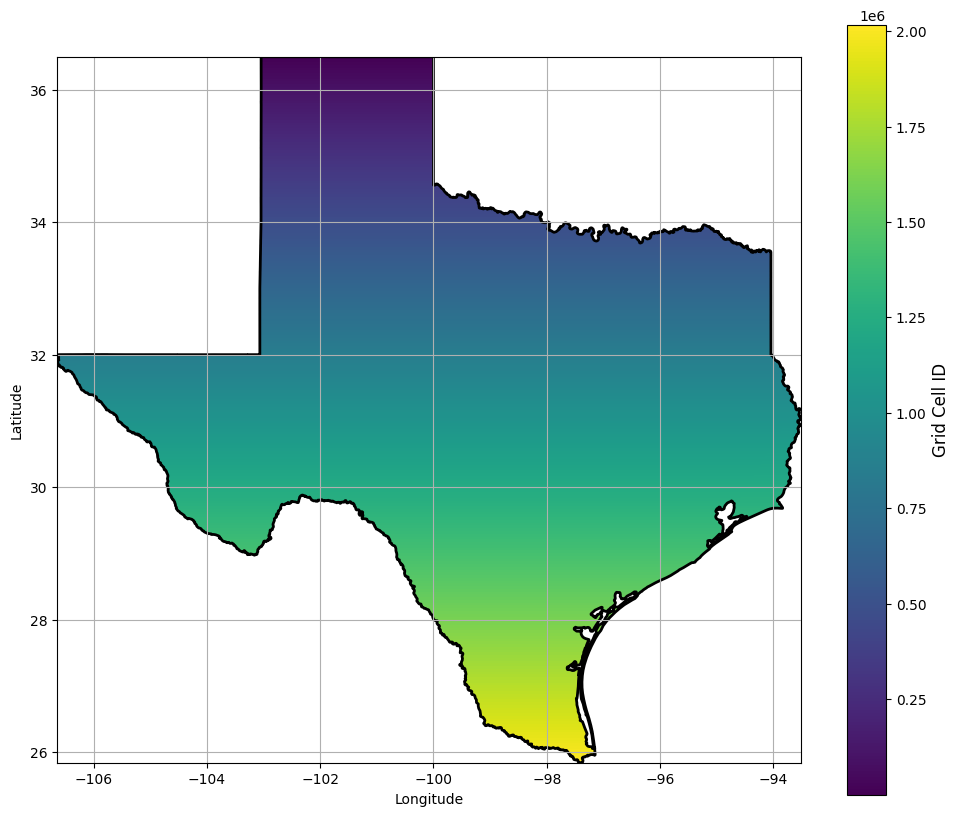

In [25]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title('Task 2: Labeled Grids Inside Texas', fontsize=16)
plot = masked_labels.plot(ax=ax, cmap='viridis', add_colorbar=True)
plot.colorbar.set_label('Grid Cell ID', size=12)
texas_shape.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
plt.show()

### Verification that the grids are labelled as innstructed

In [26]:
first_label_val = masked_labels.min().item()
last_label_val = masked_labels.max().item()

In [27]:
first_label_cell = masked_labels.where(masked_labels == first_label_val, drop=True)
lat_1, lon_1 = first_label_cell.latitude.values[0], first_label_cell.longitude.values[0]

last_label_cell = masked_labels.where(masked_labels == last_label_val, drop=True)
lat_last, lon_last = last_label_cell.latitude.values[0], last_label_cell.longitude.values[0]

C:\Users\Abolfazl HaqiqiFar\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


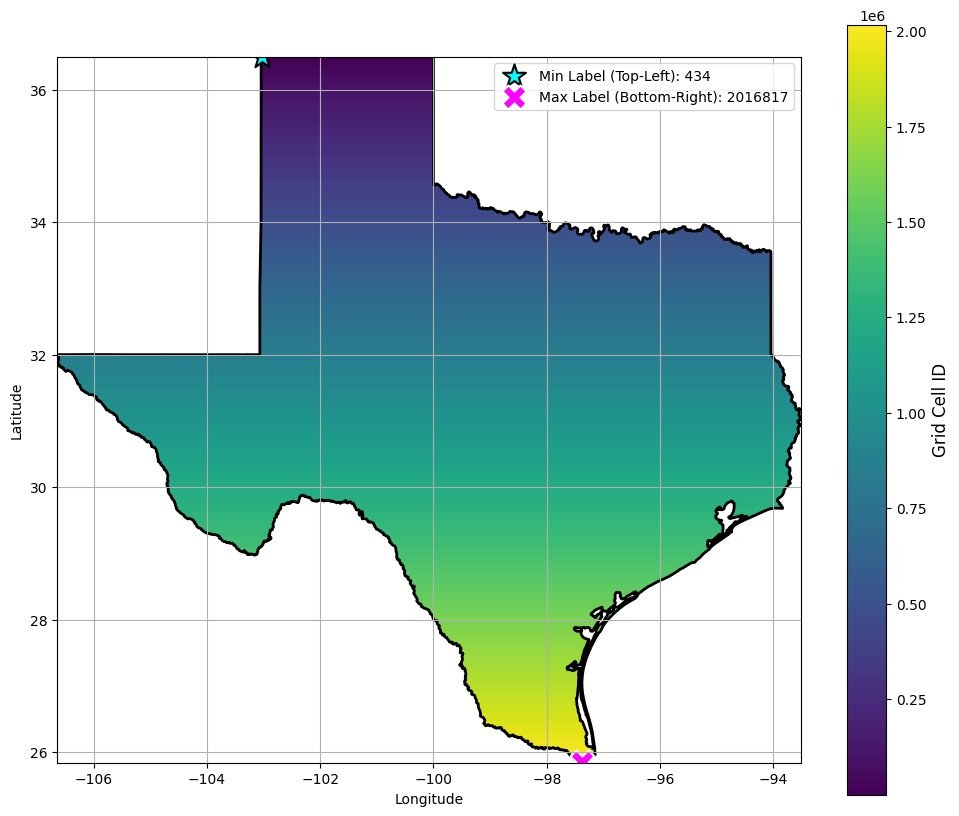

In [28]:
fig, ax = plt.subplots(figsize=(12, 10))
plot = masked_labels.plot(ax=ax, cmap='viridis', add_colorbar=True)
plot.colorbar.set_label('Grid Cell ID', size=12)
texas_shape.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)
ax.scatter(lon_1, lat_1, color='cyan', marker='*', s=300, edgecolor='black', linewidth=1.5,
           label=f'Min Label (Top-Left): {int(first_label_val)}')
ax.scatter(lon_last, lat_last, color='magenta', marker='X', s=300, edgecolor='white', linewidth=1.5,
           label=f'Max Label (Bottom-Right): {int(last_label_val)}')

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.legend()
plt.show()

### Task 3 : Change the spatial resolution from 800m to 50km. This requires keeping grid # 1, counting to grid # 51 and removing grids between 1 and 51. Repeat the same procedure all the way towards the last grid, which is grid # ~700,000. After that should have nearly 280 grids.

In [29]:
downsample_factor = 63

coarsened_labels = masked_labels.isel(
    latitude=slice(0, None, downsample_factor),
    longitude=slice(0, None, downsample_factor)
)

num_selected = int(coarsened_labels.notnull().sum().values)
print(f"Number of selected grids for Task 3: {num_selected}")

Number of selected grids for Task 3: 242


In [30]:
selected_lons, selected_lats = np.meshgrid(
    coarsened_labels.longitude.values,
    coarsened_labels.latitude.values
)

valid_mask = ~np.isnan(coarsened_labels.values)

In [31]:
#selected_lons, selected_lats = np.meshgrid(
#    coarsened_labels.longitude.values,
#    coarsened_labels.latitude.values
#)

#valid_mask = ~np.
# isnan(coarsened_labels.values)
#print(valid_mask)#print(coarsened_labels.values)

# 1. ساخت شبکه مختصات
selected_lons, selected_lats = np.meshgrid(
    coarsened_labels.longitude.values,
    coarsened_labels.latitude.values)

# 2. بررسی valid_mask
valid_mask = ~np.isnan(coarsened_labels.values)
print(f"تعداد مقادیر معتبر: {np.sum(valid_mask)}")

# 3. فیلتر کردن داده‌های معتبر
valid_lons = selected_lons[valid_mask]
valid_lats = selected_lats[valid_mask]

# 4. چاپ داده‌ها
print(valid_lons[:10])  # اولین ۱۰ مقدار از longitude‌های معتبر
print(valid_lats[:10])  # اولین ۱۰ مقدار از latitude‌های معتبر



تعداد مقادیر معتبر: 242
[-98.767916 -98.242937 -97.717958 -99.292895 -98.767916 -98.242937
 -97.717958 -99.292895 -98.767916 -98.242937]
[26.366412 26.366412 26.366412 26.891391 26.891391 26.891391 26.891391
 27.41637  27.41637  27.41637 ]


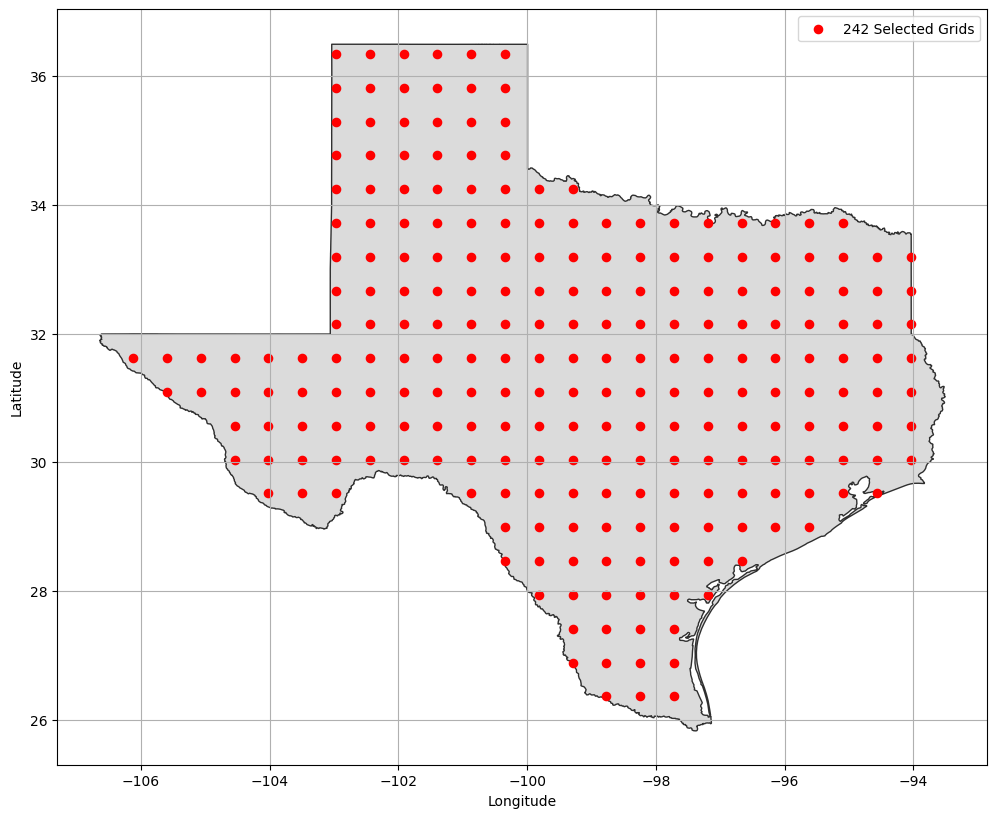

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))
texas_shape.plot(ax=ax, facecolor='lightgray', edgecolor='black', alpha=0.8)
ax.scatter(selected_lons[valid_mask], selected_lats[valid_mask], color='red', marker='o', s=35, label=f'{num_selected} Selected Grids')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.legend()
ax.set_aspect('equal', adjustable='box')
plt.show()

### Task 4 : Precipitation data is hourly based. At all ~280 grids, sum precipitation data in each day to switch to daily-based data.

In [32]:
labeled_ds = ds_texas.where(mask)
labeled_ds['grid_label'] = label_da.where(mask)
downsample_factor = 63

ds_50km = labeled_ds.isel(
    latitude=slice(0, None, downsample_factor),
    longitude=slice(0, None, downsample_factor)
)

ds_50km = ds_50km.where(ds_50km['grid_label'].notnull(), drop=True)

In [33]:
ds_50km['APCP_surface']


<xarray.DataArray 'APCP_surface' (time: 26304, latitude: 20, longitude: 24)> Size: 101MB
dask.array<where, shape=(26304, 20, 24), dtype=float64, chunksize=(720, 2, 4), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 210kB 2020-01-01 ... 2022-12-31T23:00:00
  * latitude     (latitude) float64 160B 26.37 26.89 27.42 ... 35.29 35.82 36.34
  * longitude    (longitude) float64 192B -106.1 -105.6 -105.1 ... -94.57 -94.04
    spatial_ref  int64 8B 0
Attributes:
    AORC_Contact:  aorc.info@noaa.gov
    aorc_version:  v1.1
    level:         surface
    long_name:     Total Precipitation
    short_name:    APCP_surface
    units:         kg/m^2

In [36]:
for i in range(10):
    lon = selected_lons_flat[i]
    lat = selected_lats_flat[i]
    
    # nearest match in ds_texas:
    pd = ds_texas.sel(longitude=lon, latitude=lat, method='nearest')
    
    print(i, lon, lat, np.isnan(pd['TMP_2maboveground'].isel(time=0)).values)


0 -106.64260100001889 25.841433 True
1 -106.11762200001931 25.841433 True
2 -105.59264300001973 25.841433 True
3 -105.06766400002016 25.841433 True
4 -104.54268500002058 25.841433 True
5 -104.01770600002101 25.841433 True
6 -103.49272700002143 25.841433 True
7 -102.96774800002186 25.841433 True
8 -102.44276900002228 25.841433 True
9 -101.9177900000227 25.841433 True


In [37]:
print("selected_lats range:", np.min(selected_lats_flat), "→", np.max(selected_lats_flat))
print("selected_lons range:", np.min(selected_lons_flat), "→", np.max(selected_lons_flat))


selected_lats range: 25.841433 → 36.341013
selected_lons range: -106.64260100001889 → -93.5181260000295


In [38]:
print("ds_texas latitude:", ds_texas.latitude.values[0], "→", ds_texas.latitude.values[-1])
print("ds_texas longitude:", ds_texas.longitude.values[0], "→", ds_texas.longitude.values[-1])


ds_texas latitude: 25.841433 → 36.49934
ds_texas longitude: -106.64260100001889 → -93.5181260000295


In [39]:
# === Task 3: Downsample AFTER clipping and masking ===

lat_vals = ds_texas.latitude.values
lon_vals = ds_texas.longitude.values

# Texas grid downsampled to ~50 km
selected_lats = lat_vals[::63]
selected_lons = lon_vals[::63]

selected_lons, selected_lats = np.meshgrid(selected_lons, selected_lats)

print("Downsampled grid shape:", selected_lats.shape)


Downsampled grid shape: (21, 26)


In [40]:
lon_test = selected_lons.flat[50]
lat_test = selected_lats.flat[50]

pd = ds_texas.sel(longitude=lon_test, latitude=lat_test, method='nearest')
print("Value:", pd['TMP_2maboveground'].isel(time=0).values)


Value: nan


In [41]:
# Downsample the actual Texas dataset coordinates (1 km → ~50 km)
ds_lat = ds_texas.latitude.values
ds_lon = ds_texas.longitude.values

# stride = 63
lat_down = ds_lat[::63]
lon_down = ds_lon[::63]

# Build meshgrid
selected_lons, selected_lats = np.meshgrid(lon_down, lat_down)

print("Downsampled grid shape:", selected_lats.shape)


Downsampled grid shape: (21, 26)


In [42]:
lon_test = selected_lons.flat[50]
lat_test = selected_lats.flat[50]

value = ds_texas.sel(longitude=lon_test, latitude=lat_test, method='nearest')['TMP_2maboveground'].isel(time=0).values
print(value)


nan


In [44]:
test_lat = selected_lats[0, 0]   # first selected lat
print("test_lat:", test_lat)

print("Is there any matching latitude?",
      np.isclose(test_lat, ds_texas.latitude.values).any())


test_lat: 25.841433
Is there any matching latitude? True


In [45]:
test_lon = selected_lons[0, 0]
print("test_lon:", test_lon)

print("Is there any matching longitude?",
      np.isclose(test_lon, ds_texas.longitude.values).any())


test_lon: -106.64260100001889
Is there any matching longitude? True


In [46]:
import numpy as np

tmp0 = ds_texas['TMP_2maboveground'].isel(time=0).values
mask_valid = np.isfinite(tmp0)

print("Percentage of valid temperature values:",
      100 * np.mean(mask_valid), "%")


Percentage of valid temperature values: 44.581515704314725 %


In [47]:
tmp0 = ds_texas['TMP_2maboveground'].isel(time=0)
valid_mask = np.isfinite(tmp0.values)


In [48]:
valid_lat, valid_lon = np.where(valid_mask)

# pick every Nth valid cell
stride = len(valid_lat) // 280
lat_idx = valid_lat[::stride]
lon_idx = valid_lon[::stride]


ValueError: slice step cannot be zero

In [49]:
test = ds_texas['TMP_2maboveground'].isel(time=0,
                                          latitude=lat_idx[10],
                                          longitude=lon_idx[10]).values
print(test)


NameError: name 'lat_idx' is not defined

In [55]:
tmp0 = ds_texas['TMP_2maboveground'].isel(time=0).values
valid_mask = np.isfinite(tmp0)
valid_lat_idx, valid_lon_idx = np.where(valid_mask)


In [57]:
selected_lats = ds_texas.latitude.values[lat_idx]
selected_lons = ds_texas.longitude.values[lon_idx]


In [58]:
test = ds_texas['TMP_2maboveground'].isel(
    time=0,
    latitude=lat_idx[0],
    longitude=lon_idx[0]
).values
print(test)


298.3000044450164


In [56]:
target_points = 280
total_valid = len(valid_lat_idx)

indices = np.linspace(0, total_valid - 1, target_points).astype(int)

lat_idx = valid_lat_idx[indices]
lon_idx = valid_lon_idx[indices]


In [50]:
ds_texas = ds_texas_bbox.rio.clip(texas_shape.geometry, drop=True)


In [53]:
# ds_texas is already clipped to Texas exactly using rioxarray

# Compute valid mask from temperature field
tmp0 = ds_texas['TMP_2maboveground'].isel(time=0).values
valid_mask = np.isfinite(tmp0)

# Coordinates of valid gridcells
valid_lat_idx, valid_lon_idx = np.where(valid_mask)

# Compute stride to get ~280 points
target_points = 280
stride = max(1, len(valid_lat_idx) // target_points)

# Downsample
lat_idx = valid_lat_idx[::stride]
lon_idx = valid_lon_idx[::stride]

# Use indices to extract lat/lon
selected_lats = ds_texas.latitude.values[lat_idx]
selected_lons = ds_texas.longitude.values[lon_idx]

# Meshgrid
selected_lons, selected_lats = np.meshgrid(selected_lons, selected_lats)

print("Selected grid shape:", selected_lats.shape)


Selected grid shape: (0, 0)


In [54]:
test = ds_texas['TMP_2maboveground'].isel(
    time=0,
    latitude=lat_idx[5],
    longitude=lon_idx[5]
).values

print("Temperature at a selected point:", test)


IndexError: index 5 is out of bounds for axis 0 with size 0

In [59]:
tmp0 = ds_texas['TMP_2maboveground'].isel(time=0).values
valid_mask = np.isfinite(tmp0)
valid_lat_idx, valid_lon_idx = np.where(valid_mask)


In [60]:
target_points = 280
total_valid = len(valid_lat_idx)

indices = np.linspace(0, total_valid - 1, target_points).astype(int)

lat_idx = valid_lat_idx[indices]
lon_idx = valid_lon_idx[indices]


In [61]:
selected_lats = ds_texas.latitude.values[lat_idx]
selected_lons = ds_texas.longitude.values[lon_idx]


In [62]:
test = ds_texas['TMP_2maboveground'].isel(
    time=0,
    latitude=lat_idx[0],
    longitude=lon_idx[0]
).values
print(test)


nan


In [63]:
tmp0 = ds_texas['TMP_2maboveground'].isel(time=0).values
valid_pct = np.mean(np.isfinite(tmp0)) * 100
print("Valid temperature %:", valid_pct)


Valid temperature %: 46.67691148477157


In [64]:
tmp0 = ds_texas['TMP_2maboveground'].isel(time=0).values
valid_mask = np.isfinite(tmp0)

valid_lat_idx, valid_lon_idx = np.where(valid_mask)


In [65]:
target_points = 280
total_valid = len(valid_lat_idx)

# pick evenly spaced valid points
indices = np.linspace(0, total_valid - 1, target_points).astype(int)

lat_idx = valid_lat_idx[indices]
lon_idx = valid_lon_idx[indices]


In [66]:
test = ds_texas['TMP_2maboveground'].isel(time=0,
                                          latitude=lat_idx[50],
                                          longitude=lon_idx[50]).values
print(test)


297.2000044286251


In [68]:
# ======================================================================
# 1. Identify valid gridcells in temperature field at time=0
# ======================================================================
tmp0 = ds_texas['TMP_2maboveground'].isel(time=0).values
valid_mask = np.isfinite(tmp0)

valid_lat_idx, valid_lon_idx = np.where(valid_mask)

# ======================================================================
# 2. Downsample valid gridcells to ~280 points
# ======================================================================
target_points = 280
total_valid = len(valid_lat_idx)

# uniform sampling
indices = np.linspace(0, total_valid - 1, target_points).astype(int)

lat_idx = valid_lat_idx[indices]
lon_idx = valid_lon_idx[indices]

selected_lats = ds_texas.latitude.values[lat_idx]
selected_lons = ds_texas.longitude.values[lon_idx]

print("Selected downsampled points:", len(lat_idx))

# ======================================================================
# 3. Export hourly temperature for each selected cell
# ======================================================================
output_file = "hourly_temperature_data.csv"

with open(output_file, "w") as f:
    f.write("longitude,latitude,datetime,temperature\n")

for i in range(len(lat_idx)):
    ilat = lat_idx[i]
    ilon = lon_idx[i]
    
    # Extract timeseries for this gridcell
    cell = ds_texas['TMP_2maboveground'].isel(latitude=ilat, longitude=ilon)
    
    # Convert to pandas series
    series = cell.to_series()
    
    # Write to CSV
    with open(output_file, "a") as f:
        for dt, temp in series.items():
            if np.isnan(temp):
                continue
            f.write(f"{selected_lons[i]},{selected_lats[i]},{dt},{temp}\n")

print("Temperature extraction complete:", output_file)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [35]:

selected_lons_flat = selected_lons.flatten()
selected_lats_flat = selected_lats.flatten()
output_file = "hourly_temperature_data.csv"
batch_size = 10

with open(output_file, 'w') as f:
    f.write("longitude,latitude,datetime,temperature\n")

total_records = 0

for batch_start in range(0, len(selected_lons_flat), batch_size):
    batch_end = min(batch_start + batch_size, len(selected_lons_flat))
    batch_points = selected_lons_flat[batch_start:batch_end]
    batch_lats = selected_lats_flat[batch_start:batch_end]
    
    print(f"Processing batch: points {batch_start} to {batch_end-1}")

    batch_records = 0

    for j, (lon, lat) in enumerate(zip(batch_points, batch_lats)):
        point_idx = batch_start + j
        
        try:
            # extract nearest grid cell
            point_data = ds_texas.sel(
                longitude=lon, latitude=lat,
                method='nearest'
            )
            
            # TEST if this is a valid gridcell
            if np.isnan(point_data['TMP_2maboveground'].isel(time=0).values):
                print(f"  Point {point_idx}: INVALID grid (NaN), skipping")
                continue
            
            hourly_temps = point_data['TMP_2maboveground']
            temp_series = hourly_temps.to_series()

            with open(output_file, 'a') as f:
                for datetime, temp in temp_series.items():
                    datetime_str = datetime.strftime('%Y-%m-%d %H:%M:%S')
                    f.write(f"{lon:.4f},{lat:.4f},{datetime_str},{temp:.3f}\n")
                    batch_records += 1
            
            print(f"  Point {point_idx}: {len(temp_series)} valid records")

        
        except Exception as e:
            print(f"  Error at point {point_idx}: {e}")

    total_records += batch_records
    print(f"Batch complete: {batch_records} records (Total: {total_records})")

print(f"\nProcessing complete! {total_records} total records saved to {output_file}")


Processing batch: points 0 to 9
  Point 0: INVALID grid (NaN), skipping
  Point 1: INVALID grid (NaN), skipping
  Point 2: INVALID grid (NaN), skipping
  Point 3: INVALID grid (NaN), skipping
  Point 4: INVALID grid (NaN), skipping
  Point 5: INVALID grid (NaN), skipping
  Point 6: INVALID grid (NaN), skipping
  Point 7: INVALID grid (NaN), skipping
  Point 8: INVALID grid (NaN), skipping
  Point 9: INVALID grid (NaN), skipping
Batch complete: 0 records (Total: 0)
Processing batch: points 10 to 19
  Point 10: INVALID grid (NaN), skipping
  Point 11: INVALID grid (NaN), skipping
  Point 12: INVALID grid (NaN), skipping
  Point 13: INVALID grid (NaN), skipping
  Point 14: INVALID grid (NaN), skipping


KeyboardInterrupt: 

In [47]:


selected_lons_flat = selected_lons.flatten()
selected_lats_flat = selected_lats.flatten()

output_file = "hourly_temperature_data.csv"
batch_size = 10 

with open(output_file, 'w') as f:
    f.write("longitude,latitude,datetime,temperature\n")

print(f"Processing {len(selected_lons_flat)} points in batches of {batch_size}...")

total_records = 0
for batch_start in range(0, len(selected_lons_flat), batch_size):
    batch_end = min(batch_start + batch_size, len(selected_lons_flat))
    batch_points = selected_lons_flat[batch_start:batch_end]
    batch_lats = selected_lats_flat[batch_start:batch_end]
    
    print(f"Processing batch: points {batch_start} to {batch_end-1}")
    
    batch_records = 0
    for j, (lon, lat) in enumerate(zip(batch_points, batch_lats)):
        point_idx = batch_start + j
        
        try:
            point_data = ds_texas.sel(longitude=lon, latitude=lat, method='nearest')
            hourly_temps = point_data['TMP_2maboveground']
            temp_series = hourly_temps.to_series()
            with open(output_file, 'a') as f:
                for datetime, temp in temp_series.items():
                    datetime_str = datetime.strftime('%Y-%m-%d %H:%M:%S')
                    f.write(f"{lon:.4f},{lat:.4f},{datetime_str},{temp:.2f}\n")
                    batch_records += 1
            
            print(f"  Point {point_idx}: {len(temp_series)} records")
            del point_data, hourly_temps, temp_series
            
        except Exception as e:
            print(f"  Error at point {point_idx}: {e}")
    
    total_records += batch_records
    print(f"Batch complete: {batch_records} records (Total: {total_records})")

print(f"\nProcessing complete! {total_records} total records saved to {output_file}")

Processing 546 points in batches of 10...
Processing batch: points 0 to 9


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
from dask.diagnostics import ProgressBar

# -------------------------------------------------------------
# 1. Rechunk dataset so point extraction is safe and avoids NaNs
# -------------------------------------------------------------
ds_texas = ds_texas.chunk({"time": 720, "latitude": 1, "longitude": 1})

# -------------------------------------------------------------
# 2. Flatten coordinate lists
# -------------------------------------------------------------
selected_lons_flat = selected_lons.flatten()
selected_lats_flat = selected_lats.flatten()

output_file = "hourly_temperature_data.csv"
batch_size = 10

# -------------------------------------------------------------
# 3. Create output file
# -------------------------------------------------------------
with open(output_file, "w") as f:
    f.write("longitude,latitude,datetime,temperature\n")

print(f"Processing {len(selected_lons_flat)} points in batches of {batch_size}...\n")

total_records = 0

# -------------------------------------------------------------
# 4. Iterate over batches of points
# -------------------------------------------------------------
for batch_start in range(0, len(selected_lons_flat), batch_size):
    batch_end = min(batch_start + batch_size, len(selected_lons_flat))
    batch_lons = selected_lons_flat[batch_start:batch_end]
    batch_lats = selected_lats_flat[batch_start:batch_end]

    print(f"Processing batch {batch_start} to {batch_end - 1}")
    batch_records = 0

    for j, (lon, lat) in enumerate(zip(batch_lons, batch_lats)):
        point_idx = batch_start + j

        try:
            # -------------------------------------------------
            # 4a: Safe nearest-neighbor lookup with tolerance
            # -------------------------------------------------
            point_data = ds_texas.sel(
                longitude=lon,
                latitude=lat,
                method="nearest",
                tolerance=0.02  # ≈2 km
            )

            # If nothing found (outside tolerance)
            if point_data['TMP_2maboveground'].size == 0:
                print(f"  Point {point_idx}: no nearby grid cell found (skipped)")
                continue

            # -------------------------------------------------
            # 4b: Extract hourly temperatures (Dask → NumPy)
            # -------------------------------------------------
            hourly_temps = point_data['TMP_2maboveground'].compute()

            if np.isnan(hourly_temps).all():
                print(f"  Point {point_idx}: all-NaN chunk (skipped)")
                continue

            # Convert to pandas Series for easy iteration
            temp_series = pd.Series(
                hourly_temps.values,
                index=hourly_temps['time'].values
            )

            # -------------------------------------------------
            # 4c: Write rows
            # -------------------------------------------------
            with open(output_file, "a") as f:
                for t, temp in temp_series.items():
                    datetime_str = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M:%S')
                    f.write(f"{lon:.4f},{lat:.4f},{datetime_str},{temp:.2f}\n")
                    batch_records += 1

            print(f"  Point {point_idx}: {len(temp_series)} records")

        except Exception as e:
            print(f"  Error at point {point_idx}: {e}")

    total_records += batch_records
    print(f"Batch complete: {batch_records} records (Total: {total_records})\n")

print(f"Processing complete! {total_records} total records saved to {output_file}")


In [35]:
np.diff(ds_texas.longitude.values[:10])
np.diff(ds_texas.latitude.values[:10])


array([0.008333, 0.008333, 0.008333, 0.008333, 0.008333, 0.008333,
       0.008333, 0.008333, 0.008333])

In [ ]:
#for other parameters

DLWRF = point_to_plot['DLWRF_surface']
output_file_DLWRF = "DLWRF.txt"

DSWRF = point_to_plot['DSWRF_surface']
output_file_DSWRF = "DSWRF.txt"

PRES = point_to_plot['PRES_surface']
output_file_PRES = "PRES.txt"

SPFH = point_to_plot['SPFH_2maboveground']
output_file_SPFH = "SPFH.txt"

UGRD = point_to_plot['UGRD_10maboveground']
output_file_UGRD = "UGRD.txt"

VGRD = point_to_plot['VGRD_10maboveground']
output_file_VGRD = "VGRD.txt"